## Homework 1: Applied Machine Learning

This assignment covers contents of the first three lectures. 

The emphasis for this assignment would be on the following:
1. Data Visualization and Analysis
2. Linear Models for Regression and Classification
3. Support Vector Machines

In [1]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score, accuracy_score
from sklearn.svm import LinearSVC, SVC
from sklearn.compose import make_column_transformer
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer

## Part 1: Data Visualization and Analysis

Data visualization comes in handy when we want to understand data characteristics and read patterns in datasets with thousands of samples and features.

<b>Note: Remember to label plot axes while plotting.</b>

### The dataset to be used for this section is bike_rental.csv.


In [3]:
# Load the dataset
bike_rental_df = pd.read_csv('Data/bike_rental.csv')
bike_rental_df

,month,season,holiday,weekday,working_day,weather,temp,feels_temp,humidity,windspeed,casual,registered,count
0,January,winter,No,Saturday,No,cloudy,0.344167,0.363625,0.805833,0.160446,331,654,985
1,January,winter,No,Sunday,No,cloudy,0.363478,0.353739,0.696087,0.248539,131,670,801
2,January,winter,No,Monday,Yes,clear,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,January,winter,No,Tuesday,Yes,clear,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,January,winter,No,Wednesday,Yes,clear,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,December,winter,No,Thursday,Yes,cloudy,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,December,winter,No,Friday,Yes,cloudy,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,December,winter,No,Saturday,No,cloudy,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,December,winter,No,Sunday,No,clear,0.255833,0.231700,0.483333,0.350754,364,1432,1796


<b> 1.1 Create a bar chart to compare the average bike rental count on holiday and non-holiday weekdays. Are there differences in rental patterns? </b>

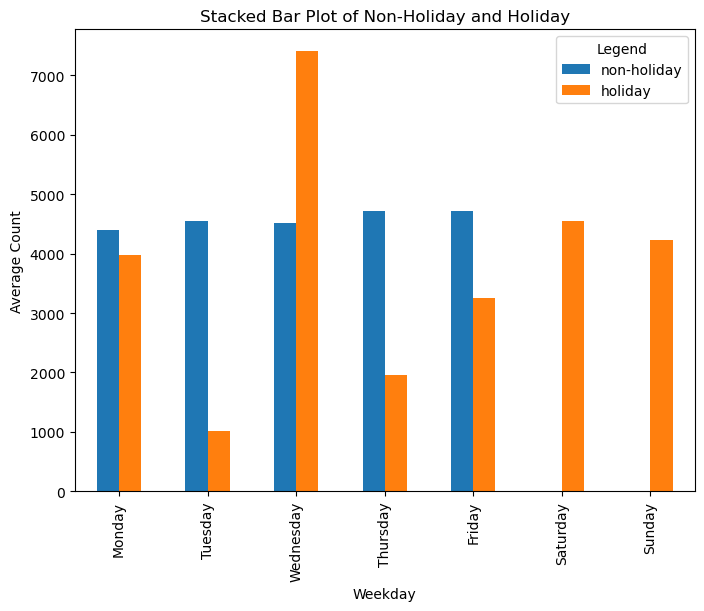

In [70]:
# find the unique weekday
weekday = list(bike_rental_df['weekday'].unique())
# reorder the weekday
weekday = weekday[2:] + weekday[:2]
# groupby the weekday when it's working day
nonholi_byweekday = bike_rental_df[bike_rental_df['working_day'] == 'Yes'].groupby('weekday')['count'].mean()
# groupby the weekday when it's holiday
holi_byweekday = bike_rental_df[bike_rental_df['working_day'] == 'No'].groupby('weekday')['count'].mean()

df1 = pd.DataFrame({'Weekday': weekday})
df1.set_index('Weekday', inplace=True)
df1['non-holiday'] = nonholi_byweekday
df1['holiday'] = holi_byweekday
ax = df1.plot(kind='bar', figsize=(8, 6))

plt.xlabel('Weekday')
plt.ylabel('Average Count')
plt.title('Stacked Bar Plot of Non-Holiday and Holiday')
plt.legend(title='Legend')
plt.show()

### Comment here
In a typical workweek, where Monday through Friday are working days and the weekend is off, the average bike rental count remains fairly consistent across these days. However, when Wednesday is designated as a holiday, a significant spike in bike rentals is observed. This substantial increase is likely due to the "midweek break". Many people may opt to extend this holiday by taking Thursday and Friday off as well, so this provides an opportunity for people to engage in activities like bike riding. 

<b> 1.2 Plot a small multiple of bar charts to understand data distribution of the following categorical variables. </b>
1. month 
2. season
3. working_day
4. weather
<b></b>

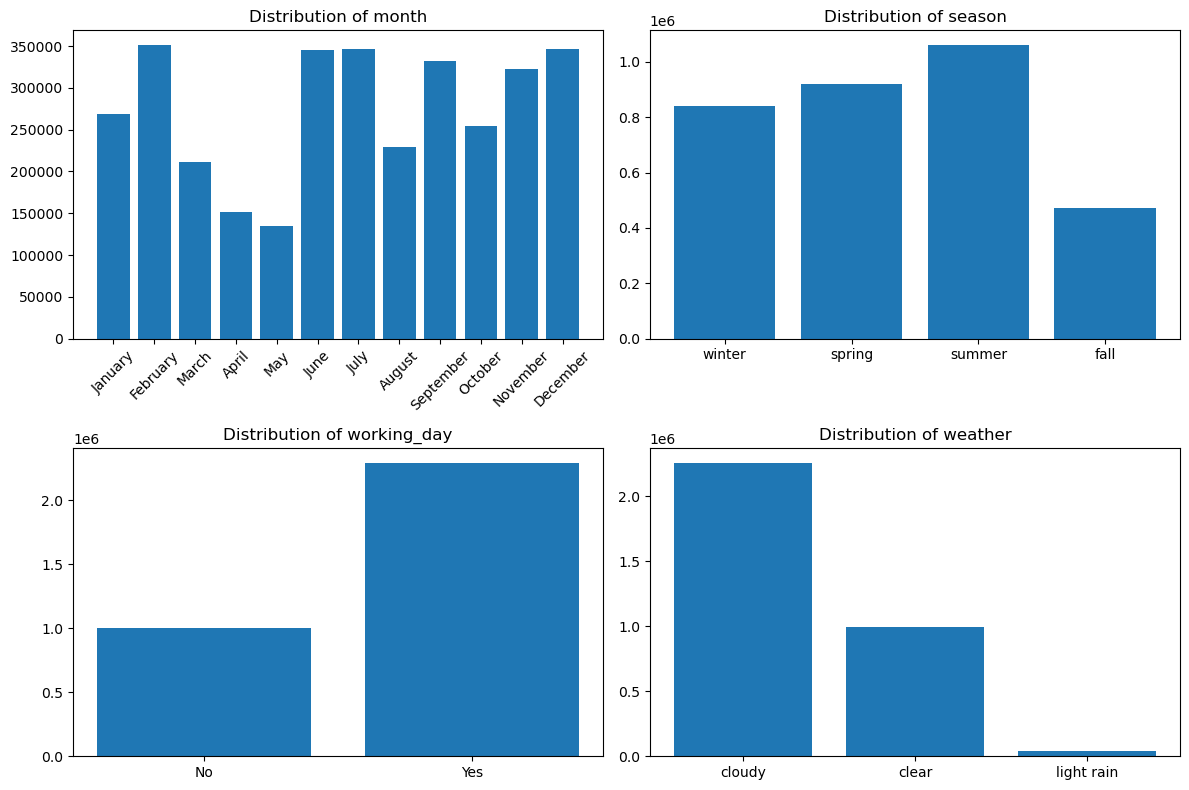

In [68]:
### Code here
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
categorical_vars = ['month', 'season', 'working_day', 'weather']
for i, var in enumerate(categorical_vars):
    row = i // 2  
    col = i % 2 
    unique_values = bike_rental_df[var].unique()
    value_counts = bike_rental_df.groupby(var)['count'].sum()
    axes[row, col].bar(unique_values, value_counts)
    axes[row, col].set_title(f'Distribution of {var}')
    if i == 0:
        axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


<b> 1.3 Compare the number of registered and casual bike rentals over time by month. Create a stacked bar chart to show the contributions of each user type. </b>

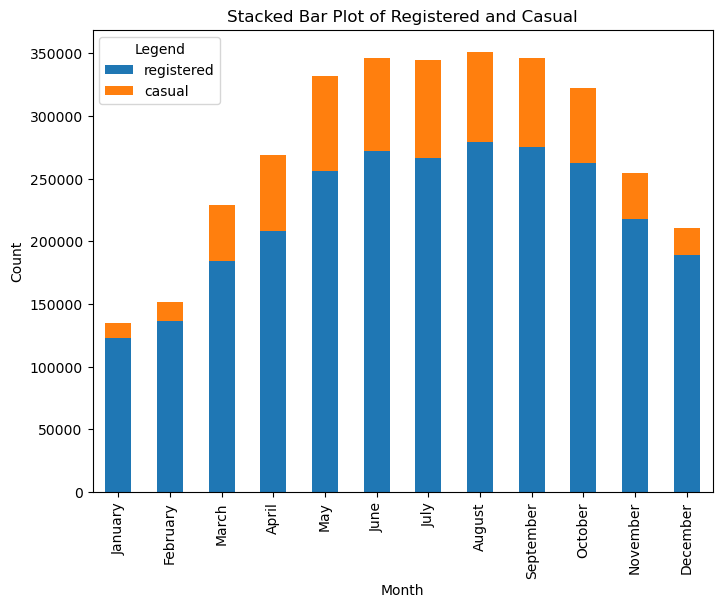

In [6]:
### Code here

month = list(bike_rental_df['month'].unique())
# calculate sum of the registered & casual bike rentals by month
registered_by_month = bike_rental_df.groupby('month')['registered'].sum()
casual_by_month = bike_rental_df.groupby('month')['casual'].sum()

# create a new df used for visualization
df = pd.DataFrame({'Month': month})
df.set_index('Month', inplace=True)
df['registered'] = registered_by_month
df['casual'] = casual_by_month
ax = df.plot(kind='bar', stacked=True, figsize=(8, 6))

plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Stacked Bar Plot of Registered and Casual')
plt.legend(title='Legend')
plt.show()

<b> 1.4 Plot relationships between the following features and the target variable count as a small multiple of scatter plots. </b>

1. temp
2. feels_temp
3. humidity
4. windspeed
<b></b>

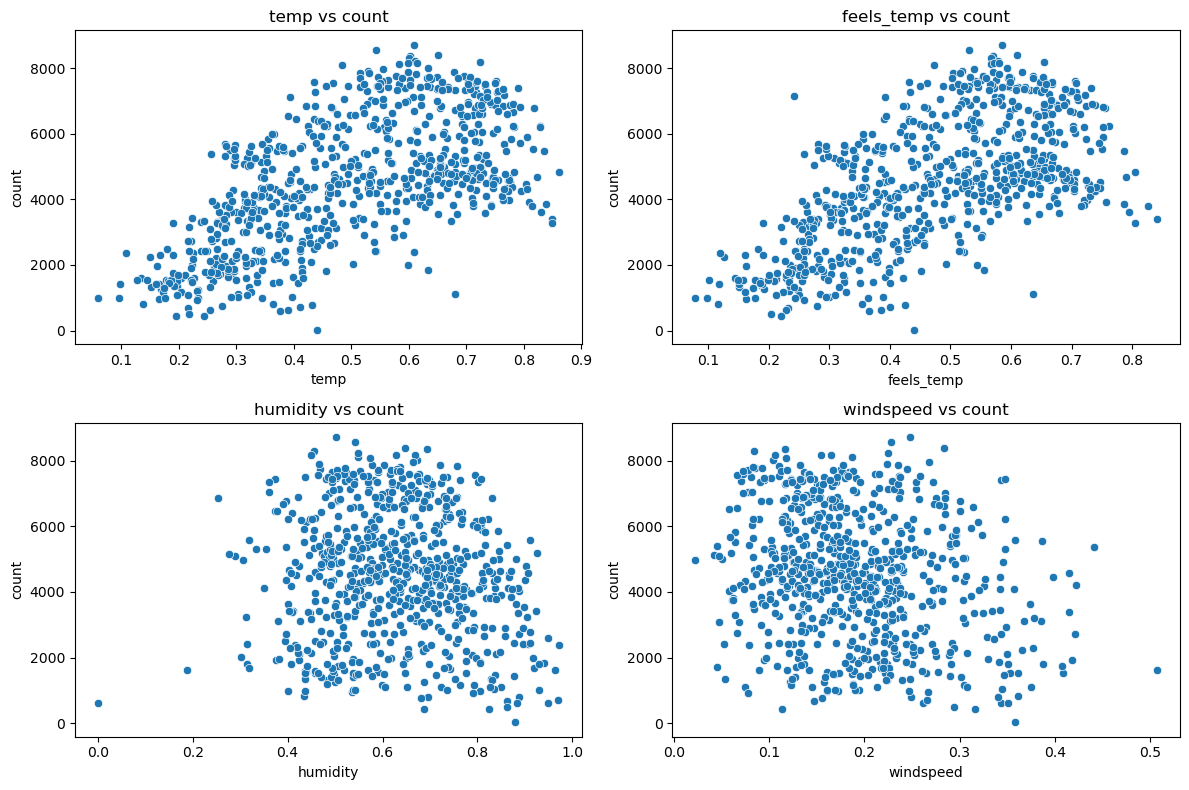

In [7]:
### Code here

features = ['temp', 'feels_temp', 'humidity', 'windspeed']
target = 'count'
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)  
    sns.scatterplot(data=bike_rental_df, x=feature, y=target)
    plt.title(f'{feature} vs {target}')

plt.tight_layout()
plt.show()

## Part 2: Linear Models for Regression and Classification

In this section, we will be implementing three linear models **linear regression, logistic regression, and SVM**. We will see that despite some of their differences at the surface, these linear models (and many machine learning models in general) are fundamentally doing the same thing - that is, optimizing model parameters to minimize a loss function on data.

### 2.1 Linear Regression


The objective of this dataset is to predict the count of bike rentals based on weather and time. We will use linear regression to predict the count using weather and time. 

In [8]:
# split data into features and labels

bike_rental_X = bike_rental_df.drop(columns=['count'])
bike_rental_y = bike_rental_df['count']
bike_rental_X

,month,season,holiday,weekday,working_day,weather,temp,feels_temp,humidity,windspeed,casual,registered
0,January,winter,No,Saturday,No,cloudy,0.344167,0.363625,0.805833,0.160446,331,654
1,January,winter,No,Sunday,No,cloudy,0.363478,0.353739,0.696087,0.248539,131,670
2,January,winter,No,Monday,Yes,clear,0.196364,0.189405,0.437273,0.248309,120,1229
3,January,winter,No,Tuesday,Yes,clear,0.200000,0.212122,0.590435,0.160296,108,1454
4,January,winter,No,Wednesday,Yes,clear,0.226957,0.229270,0.436957,0.186900,82,1518
...,...,...,...,...,...,...,...,...,...,...,...,...
726,December,winter,No,Thursday,Yes,cloudy,0.254167,0.226642,0.652917,0.350133,247,1867
727,December,winter,No,Friday,Yes,cloudy,0.253333,0.255046,0.590000,0.155471,644,2451
728,December,winter,No,Saturday,No,cloudy,0.253333,0.242400,0.752917,0.124383,159,1182
729,December,winter,No,Sunday,No,clear,0.255833,0.231700,0.483333,0.350754,364,1432


**2.1.1 Plot the relationships between the label (count) and the continuous features (temp, feels_temp, humidity, windspeed, casual, registered) using a small multiple of scatter plots. Make sure to label the axes.**

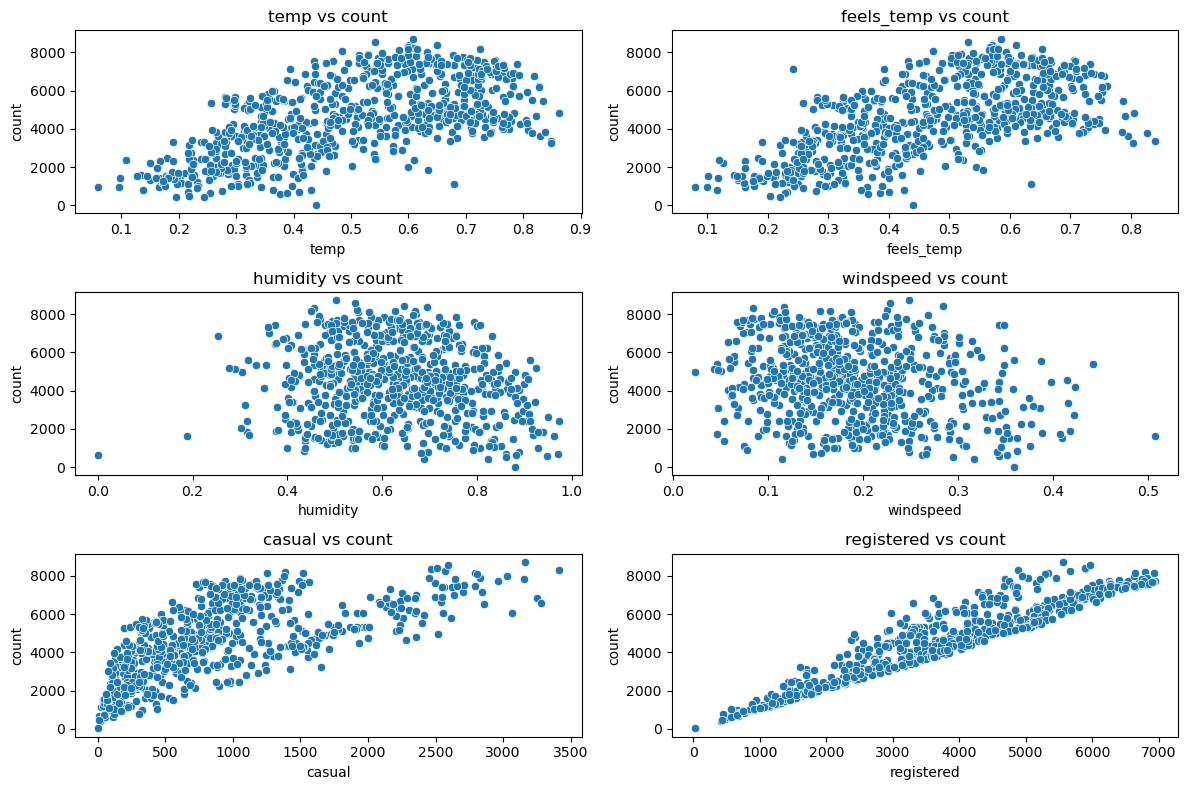

In [9]:
### Code here
features = ['temp', 'feels_temp', 'humidity', 'windspeed', 'casual', 'registered']
target = 'count'
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(3, 2, i+1)  
    sns.scatterplot(data=bike_rental_df, x=feature, y=target)
    plt.title(f'{feature} vs {target}')
plt.tight_layout()
plt.show()

**2.1.2 From the visualizations above, do you think linear regression is a good model for this problem? Why and/or why not? Please explain.**

### Comment here
Yes, I think linear regression is a good model for this problem, as most of the continuous features have linear relation with the target variable(count). Also, the data doesn't have extreme outliers or data points that deviate significantly from the overall pattern. 

### Data Preprocessing

Before we can fit a linear regression model, there are several pre-processing steps we should apply to the datasets:

1. Encode categorial features appropriately.
2. Remove highly collinear features by reading the correlation plot.
3. Split the dataset into training (60%), validation (20%), and test (20%) sets.
4. Standardize the columns in the feature matrices X_train, X_val, and X_test to have zero mean and unit variance. To avoid information leakage, learn the standardization parameters (mean, variance) from X_train, and apply it to X_train, X_val, and X_test.
5. Add a column of ones to the feature matrices X_train, X_val, and X_test. This is a common trick so that we can learn a coefficient for the bias term of a linear model.


**2.1.3 Encode the categorical variables of the Bike Rental dataset.**

In [72]:
### Code here

# select categorical data
cat_df = bike_rental_X.select_dtypes('object')

# do one-hot-encoding except "month"
cat_df_transformed = pd.get_dummies(cat_df.drop('month',axis = 1 ))

# do targetencoding on "month"
encoder = TargetEncoder()
encoded_col = encoder.fit_transform(bike_rental_X['month'], bike_rental_y)

# select numerical data
num_df = bike_rental_X.select_dtypes(include=[np.number])

# combine all
bike_rental_X_encoded = pd.concat([encoded_col, cat_df_transformed, num_df], axis = 1)

**2.1.4 Plot the correlation matrix, and check if there is high correlation between the given numerical features (Threshold >=0.9). If yes, drop one from each pair of highly correlated features from the dataframe. Why is necessary to drop those columns before proceeding further?**

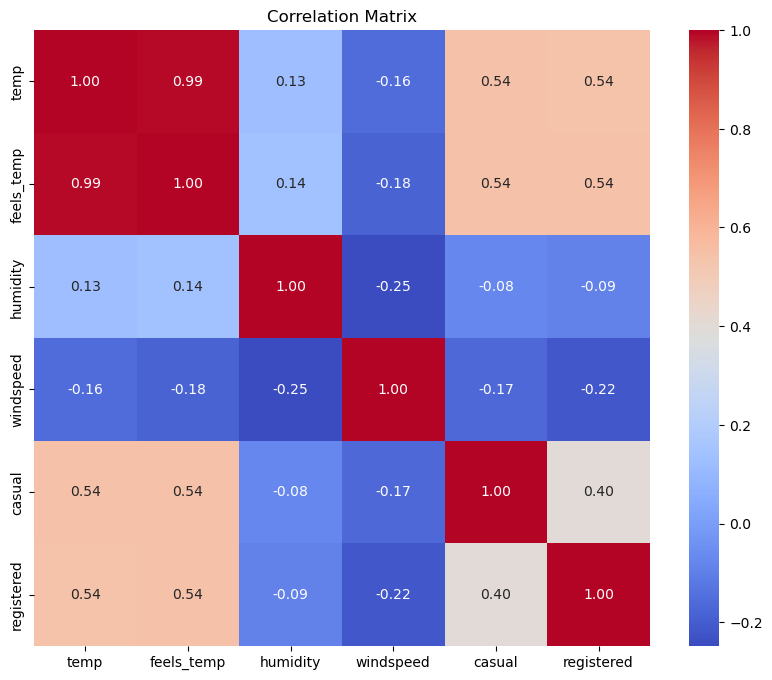

In [73]:
### Code here
numerical_df = bike_rental_X.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.show()

In [75]:
### Code here
bike_rental_X_encoded = bike_rental_X_encoded.drop(["feels_temp", "casual", "registered"], axis=1)

### Comment here
1. The heatmap tells that "feels_temp" and "temp" are highly correlated, so I decide to drop "feels_temp" and keep "temp". Additionally, by following the correction, I am going to drop these "casual" and "registered" before running linear model. 
2. If not doing so, it would produce multicollinearity, making it difficult to seperate the individual effects of each variable on target variable. In addition, it reduces model interpretability, as it become challenging to clarify which variable is truly contributing to the prediction. 

**2.1.5 Split the dataset into training (60%), validation (20%), and test (20%) sets.**

In [76]:
### Code here
X_dev, X_test, y_dev, y_test = train_test_split(bike_rental_X_encoded, bike_rental_y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, random_state=2) # default = 3:1

**2.1.6 Standardize the columns in the feature matrices.**

In [77]:
### Code here
scaler = StandardScaler()
bike_rental_X_train = scaler.fit_transform(X_train)   # Fit and transform scalar on X_train
bike_rental_X_val = scaler.transform(X_val)           # Transform X_val
bike_rental_X_test = scaler.transform(X_test)         # Transform X_test


In [78]:
# Adding a column of ones to the feature matrices for the bias term.

bike_rental_X_train = np.hstack([np.ones((bike_rental_X_train.shape[0], 1)), bike_rental_X_train])
bike_rental_X_val = np.hstack([np.ones((bike_rental_X_val.shape[0], 1)), bike_rental_X_val])
bike_rental_X_test = np.hstack([np.ones((bike_rental_X_test.shape[0], 1)), bike_rental_X_test])

At the end of this pre-processing, you should have the following vectors and matrices: 
- Bike Rental Prediction dataset: bike_rental_X_train, bike_rental_X_val, bike_rental_X_test, bike_rental_y_train, bike_rental_y_val, bike_rental_y_test

### Implement Linear Regression

Now, we can implement our linear regression model! Specifically, we will be implementing ridge regression, which is linear regression with L2 regularization. Given an (m x n) feature matrix $X$, an (m x 1) label vector $y$, and an (n x 1) weight vector $w$, the hypothesis function for linear regression is:

$$
y = X w
$$

Note that we can omit the bias term here because we have included a column of ones in our $X$ matrix, so the bias term is learned implicitly as a part of $w$. This will make our implementation easier.

Our objective in linear regression is to learn the weights $w$ which best fit the data. This notion can be formalized as finding the optimal $w$ which minimizes the following loss function:

$$
\min_{w} \| X w - y \|^2_2 + \alpha \| w \|^2_2 \\
$$

This is the ridge regression loss function. The $\| X w - y \|^2_2$ term penalizes predictions $Xw$ which are not close to the label $y$. And the $\alpha \| w \|^2_2$ penalizes large weight values, to favor a simpler, more generalizable model. The $\alpha$ hyperparameter, known as the regularization parameter, is used to tune the complexity of the model - a higher $\alpha$ results in smaller weights and lower complexity, and vice versa. Setting $\alpha = 0$ gives us vanilla linear regression.

Conveniently, ridge regression has a closed-form solution which gives us the optimal $w$ without having to do iterative methods such as gradient descent. The closed-form solution, known as the Normal Equations, is given by:

$$
w = (X^T X + \alpha I)^{-1} X^T y
$$

**2.1.7 Implement a `LinearRegression` class with two methods: `train` and `predict`.**

**Note: You may NOT use sklearn for this implementation. You may, however, use `np.linalg.solve` to find the closed-form solution. It is highly recommended that you vectorize your code.**

In [16]:
class LinearRegression():
    '''
    Linear regression model with L2-regularization (i.e. ridge regression).

    Attributes
    ----------
    alpha: regularization parameter
    w: (n x 1) weight vector
    '''
    
    def __init__(self, alpha=0):
        self.alpha = alpha
        self.w = None

    def train(self, X, y):
        '''Trains model using ridge regression closed-form solution 
        (sets w to its optimal value).
        
        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector
        
        Returns
        -------
        None
        '''
        ### Your code here
        xtx = np.dot(X.T, X) # n*n
        alphaI = self.alpha * np.identity(xtx.shape[0]) # shape[0] = n
        XTy = np.dot(X.T, y)
        inverse_term = np.linalg.inv(xtx + alphaI)
        self.w = np.dot(inverse_term, XTy)
        
    def predict(self, X):
        '''Predicts on X using trained model.
        
        Parameters
        ----------
        X : (m x n) feature matrix
        
        Returns
        -------
        y_pred: (m x 1) prediction vector
        '''
        ### Your code here
        y_pred = np.dot(X, self.w)
        return y_pred
        
    def r2(self, y_true, y_pred):
        mean_y_true = np.mean(y_true)
        # total sum of squares 
        tss = np.sum((y_true - mean_y_true)**2)
        # residual sum of squares
        rss = np.sum((y_true - y_pred)**2)
        # calculate R-squared 
        rsq = 1 - (rss / tss)
        return rsq


### Train, Evaluate, and Interpret LR Model

**2.1.8 Train a linear regression model ($\alpha = 0$) on the bike rental training data. Make predictions and report the $R^2$ score on the training, validation, and test sets. Report the first 3 and last 3 predictions on the test set, along with the actual labels.**

In [17]:
def get_report(y_pred, y_test):
    """
    function to Report the first 3 and last 3 predictions on X_test,
    along with the actual labels in y_test.
    
    Returns a dataframe with 6 rows.
    """
    preds = np.concatenate([y_pred[:3], y_pred[-3:]])
    actuals = np.concatenate([y_test[:3], y_test[-3:]])
    df_compare = pd.DataFrame({'Prediction': preds,
                               'Actual':actuals})
    df_compare['Position'] = [1, 2, 3, len(y_pred) - 2, len(y_pred) - 1, len(y_pred)]
    df_compare = df_compare.set_index('Position')
    return df_compare

In [79]:
### Code here
l = LinearRegression(alpha = 0)
l.train(bike_rental_X_train, y_train)
y_pred_train = l.predict(bike_rental_X_train)
y_pred_val = l.predict(bike_rental_X_val)
y_pred_test = l.predict(bike_rental_X_test)
print("R^2 score on the training sets:", r2_score(y_train, y_pred_train))
print("R^2 score on the validation sets:", r2_score(y_val, y_pred_val))
print("R^2 score on the testing sets:", r2_score(y_test, y_pred_test))
print(get_report(y_pred_test, y_test))

R^2 score on the training sets: 0.5284717580779043
R^2 score on the validation sets: 0.5658722620926013
R^2 score on the testing sets: 0.5771879909991071
           Prediction  Actual
Position                     
1         2933.156206    3830
2         2003.163251    2114
3         6905.343042    3915
145       2607.765404    1538
146       3334.530982    5382
147       2938.193073     623


**2.1.9 As a baseline model, use the mean of the training labels (bike_rental_y_train) as the prediction for all instances. Report the $R^2$ on the training, validation, and test sets using this baseline.** 

>This is a common baseline used in regression problems and tells you if your model is any good. Your linear regression $R^2$ should be much higher than these baseline $R^2$.

In [81]:
### Code here
mean_train = sum(y_train)/len(y_train)
mean_train_list = [mean_train]*len(y_train)
mean_val_list = [mean_train]*len(y_val)
mean_test_list = [mean_train]*len(y_test)
print("baseline model:")
print("Baseline R^2 score on the training sets: {:.4f}".format(r2_score(y_train, mean_train_list)))
print("Baseline R^2 score on the validation sets: {:.4f}".format(r2_score(y_val, mean_val_list)))
print("Baseline R^2 score on the testing sets: {:.4f}".format(r2_score(y_test,mean_test_list)))

baseline model:
Baseline R^2 score on the training sets: 0.0000
Baseline R^2 score on the validation sets: -0.0759
Baseline R^2 score on the testing sets: -0.0935


**2.1.10 Interpret your model trained on the bike rental dataset using a bar chart of the model weights. Make sure to label the bars (x-axis) and don't forget the bias term!**

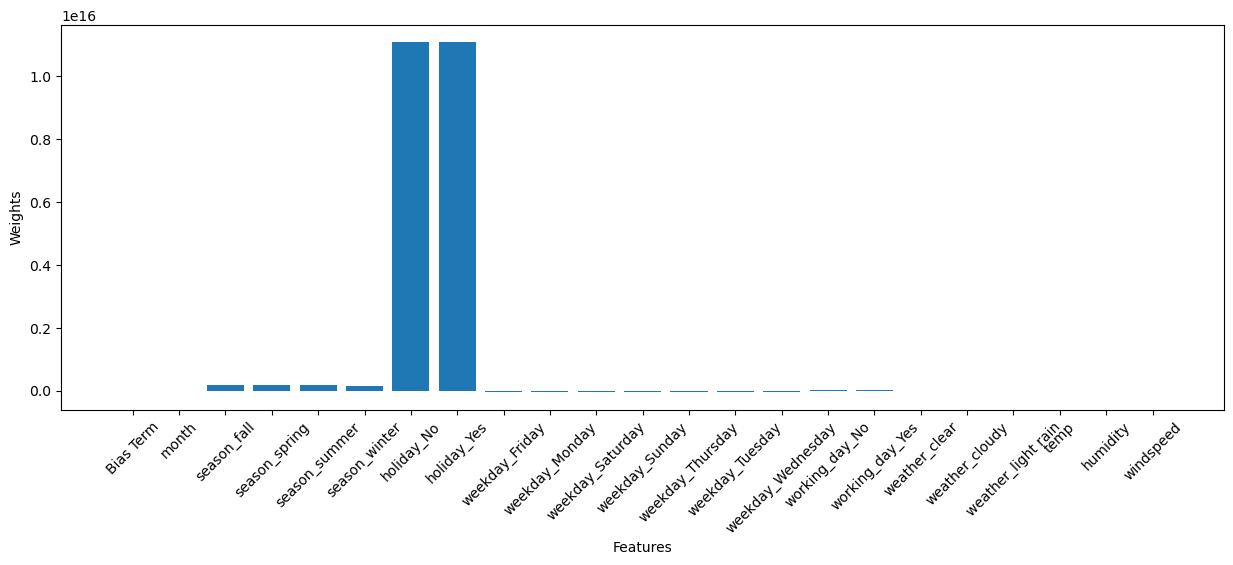

In [82]:
### Code here
col_name = ["Bias Term"] + list(bike_rental_X_encoded.columns)
plt.figure(figsize=(15, 5))
plt.bar(col_name, l.w)
plt.xlabel('Features')
plt.ylabel('Weights')
plt.tick_params(axis='x', rotation=45)

**2.1.11 According to your model, which features are the greatest contributors to the car price?**

### Comment here
Both holiday_no and holiday_yes are the greatest contributors to the bike count, as both are the two highest height of the bar

### Hyperparameter Tuning ($\alpha$)

Now, let's do ridge regression and tune the $\alpha$ regularization parameter on the bike rental dataset.

**2.1.12 Sweep out values for $\alpha$ using alphas = np.logspace(-5, 1, 20). Perform a grid search over these $\alpha$ values, recording the training and validation $R^2$ for each $\alpha$. A simple grid search is fine, no need for k-fold cross validation. Plot the training and validation $R^2$ as a function of $\alpha$ on a single figure. Make sure to label the axes and the training and validation $R^2$ curves. Use a log scale for the x-axis.**

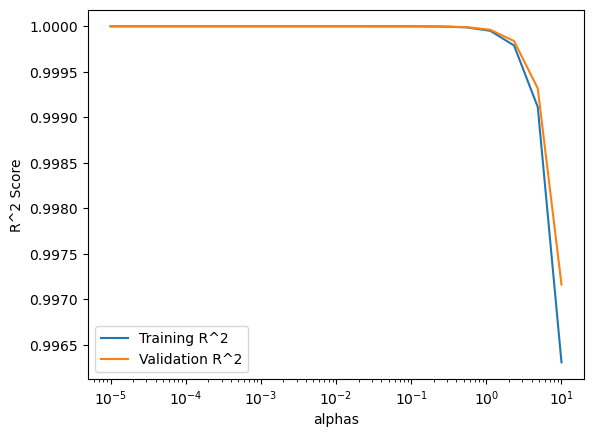

In [22]:
### Code here
alphas = np.logspace(-5, 1, 20)

# setup the empty arrays to store R^2 value
train_scores = np.zeros(len(alphas))
val_scores = np.zeros(len(alphas))

# run through all alphas
for i, alpha in enumerate(alphas):
    ll = LinearRegression(alpha=alpha)
    ll.train(bike_rental_X_train, y_train)
    train_scores[i] = r2_score(y_train, ll.predict(bike_rental_X_train))
    val_scores[i] = r2_score(y_val, ll.predict(bike_rental_X_val))


# Plot the training and validation R^2 scores
plt.semilogx(alphas, train_scores, label='Training R^2')
plt.semilogx(alphas, val_scores, label='Validation R^2')
plt.xlabel('alphas')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

**2.1.13 Explain your plot above. How do training and validation $R^2$ behave with decreasing model complexity (increasing $\alpha$)?**

### Comment here
the R^2 of the training and validation both decrease as the alpha increases. 

### 2.2 Logistic Regression

**2.2.1 Load the dataset, the dataset to be used is loan_data.csv**

In [23]:
### Code here
loan_data_df = pd.read_csv('Data/loan_data.csv')

In [24]:
loan_data_df = loan_data_df.drop(columns=['Loan_ID'])

In [25]:
loan_data_df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


**2.2.2 Are there any missing values in the dataset? If so, what is the best way to deal with it and why?**

In [26]:
### Code here
check_missing_count = loan_data_df.isnull().sum()
check_missing_percent = check_missing_count/loan_data_df.shape[0]
print(pd.concat({'check_missing_count':check_missing_count, 
                 'check_missing_percent':check_missing_percent,
                 'data type': loan_data_df.dtypes,
                 'nunique': loan_data_df.nunique()} ,axis=1))

                   check_missing_count  check_missing_percent data type  \
Gender                              13               0.021173    object   
Married                              3               0.004886    object   
Dependents                          15               0.024430    object   
Education                            0               0.000000    object   
Self_Employed                       32               0.052117    object   
ApplicantIncome                      0               0.000000     int64   
CoapplicantIncome                    0               0.000000   float64   
LoanAmount                          22               0.035831   float64   
Loan_Amount_Term                    14               0.022801   float64   
Credit_History                      50               0.081433   float64   
Property_Area                        0               0.000000    object   
Loan_Status                          0               0.000000    object   

                   nuniq

In [27]:
### Code here

# loan_data missing and categorical data
loan_missing_cat = ['Gender', 'Married', 'Dependents', 'Self_Employed']
# loan_data missing and numerical data
loan_missing_num = ['LoanAmount', 'Loan_Amount_Term', 'Credit_History']

# fill all categorical missing value with mode (DataFrame)
for col in loan_missing_cat:
    mode_val = loan_data_df[col].mode()[0]
    loan_data_df[col].fillna(mode_val, inplace=True)
# fill all numerical missing value with mean (Series)
loan_data_df[loan_missing_num] = loan_data_df[loan_missing_num].fillna(loan_data_df[loan_missing_num].mean())

# check again
print(loan_data_df.isnull().sum())

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


### Comment here
The missing value in the column account for a few percentage of the whole data, so I decide to fill the na with mode and mean for categorical data and numerical data, respectively. 

**2.2.3 Encode the categorical variables.**

In [28]:
### Code here
loan_data_df_X = loan_data_df.drop(columns=['Loan_Status'])
loan_data_df_y = loan_data_df['Loan_Status']

# df contains categorical variables
loan_cat_df = loan_data_df_X.select_dtypes('object')
# df contains numerical variables
loan_num_df = loan_data_df_X.select_dtypes(include=[np.number])

# one-hot-encoding
loan_cat_df_transformed = pd.get_dummies(loan_cat_df)

# combine all
loan_X_encoded = pd.concat([loan_cat_df_transformed, loan_num_df], axis = 1)


**2.2.4 Do you think that the distribution of labels is balanced? Why/why not? Hint: Find the probability of the different categories.**

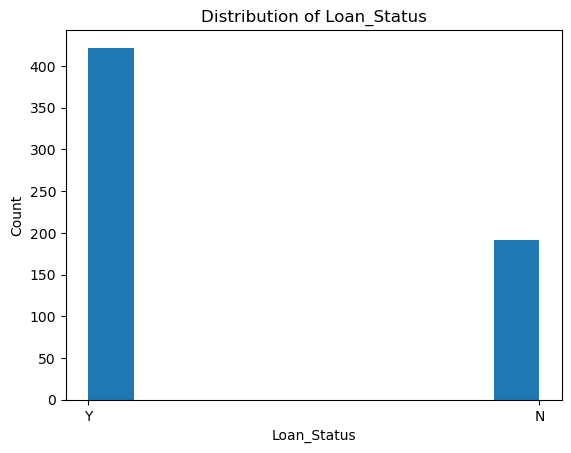

In [29]:
### Code here
plt.hist(loan_data_df_y)
plt.xlabel('Loan_Status')
plt.ylabel('Count')
plt.title('Distribution of Loan_Status')
plt.show()

### Comment here
The majority of the cases fall into the "Y" category of Loan_Status, so I think it's not balanced labels

**2.2.5 Plot the correlation matrix (first separate features and Y variable), and check if there is high correlation between the given numerical features (Threshold >=0.9). If yes, drop those highly correlated features from the dataframe.**

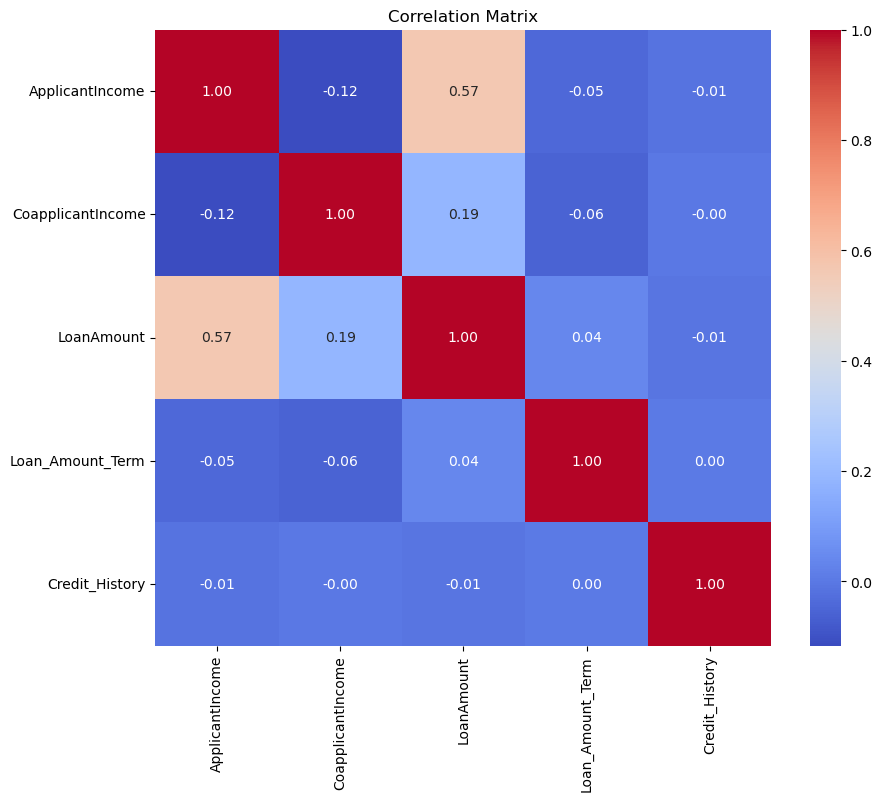

In [30]:
### Code here
loan_data_df_X = loan_data_df.drop(columns=['Loan_Status'])
loan_data_df_y = loan_data_df['Loan_Status'].replace({'Y':1, 'N':0})
loan_num_df = loan_data_df_X.select_dtypes(include=[np.number])
correlation_matrix = loan_num_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.show()

All the correlation between numerical variables are less than 0.9, so I will keep all the numerical features

**2.2.6 Apply the following pre-processing steps:**

1. Convert the label from a Pandas series to a Numpy (m x 1) vector. If you don't do this, it may cause problems when implementing the logistic regression model.
2. Split the dataset into training (60%), validation (20%), and test (20%) sets.
3. Standardize the columns in the feature matrices. To avoid information leakage, learn the standardization parameters from training, and then apply training, validation and test dataset.
4. Add a column of ones to the feature matrices of train, validation and test dataset. This is a common trick so that we can learn a coefficient for the bias term of a linear model.

In [31]:
# 1. convert the label
loan_data_df_y_np = np.array(loan_data_df_y).reshape(-1,1)

# 2. split the dataset
X_dev, X_test, y_dev, y_test = train_test_split(loan_X_encoded, loan_data_df_y_np, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=0)

# 3. Standardize the columns in the feature matrics 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   # Fit and transform scalar on X_train
X_val = scaler.transform(X_val)           # Transform X_val
X_test = scaler.transform(X_test)         # Transform X_test

# 4. Add bias term
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_val = np.hstack([np.ones((X_val.shape[0], 1)), X_val])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

### Implement Logisitc Regression

We will now implement logistic regression with L2 regularization. Given an (m x n) feature matrix $X$, an (m x 1) label vector $y$, and an (n x 1) weight vector $w$, the hypothesis function for logistic regression is:

$$
y = \sigma(X w)
$$

where $\sigma(x) = \frac{1}{1 + e^{-x}}$, i.e. the sigmoid function. This function scales the prediction to be a probability between 0 and 1, and can then be thresholded to get a discrete class prediction.

Just as with linear regression, our objective in logistic regression is to learn the weights $𝑤$ which best fit the data. For L2-regularized logistic regression, we find an optimal $w$ to minimize the following loss function:

$$
\min_{w} \ -y^T \ \text{log}(\sigma(Xw)) \ - \  (\mathbf{1} - y)^T \ \text{log}(\mathbf{1} - \sigma(Xw)) \ + \ \alpha \| w \|^2_2 \\
$$

Unlike linear regression, however, logistic regression has no closed-form solution for the optimal $w$. So, we will use gradient descent to find the optimal $w$. The (n x 1) gradient vector $g$ for the loss function above is:

$$
g = X^T \Big(\sigma(Xw) - y\Big) + 2 \alpha w
$$

Below is pseudocode for gradient descent to find the optimal $w$. You should first initialize $w$ (e.g. to a (n x 1) zero vector). Then, for some number of epochs $t$, you should update $w$ with $w - \eta g $, where $\eta$ is the learning rate and $g$ is the gradient. You can learn more about gradient descent [here](https://www.coursera.org/lecture/machine-learning/gradient-descent-8SpIM).

> $w = \mathbf{0}$
>
> $\text{for } i = 1, 2, ..., t$
>
> $\quad \quad w = w - \eta g $


**A LogisticRegression class with five methods: train, predict, calculate_loss, calculate_gradient, and calculate_sigmoid has been implemented for you below.**

In [32]:
class LogisticRegression():
    '''
    Logistic regression model with L2 regularization.

    Attributes
    ----------
    alpha: regularization parameter
    t: number of epochs to run gradient descent
    eta: learning rate for gradient descent
    w: (n x 1) weight vector
    '''

    def __init__(self, alpha=0, t=100, eta=1e-3):
        self.alpha = alpha
        self.t = t
        self.eta = eta
        self.w = None

    def train(self, X, y):
        '''Trains logistic regression model using gradient descent
        (sets w to its optimal value).

        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector

        Returns
        -------
        losses: (t x 1) vector of losses at each epoch of gradient descent
        '''

        loss = list()
        self.w = np.zeros((X.shape[1],1))
        for i in range(self.t):
            self.w = self.w - (self.eta * self.calculate_gradient(X, y))
            loss.append(self.calculate_loss(X, y))
        return loss

    def predict(self, X):
        '''Predicts on X using trained model. Make sure to threshold
        the predicted probability to return a 0 or 1 prediction.

        Parameters
        ----------
        X : (m x n) feature matrix

        Returns
        -------
        y_pred: (m x 1) 0/1 prediction vector
        '''
        y_pred = self.calculate_sigmoid(X.dot(self.w))
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        return y_pred

    def calculate_loss(self, X, y):
        '''Calculates the logistic regression loss using X, y, w,
        and alpha. Useful as a helper function for train().

        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector

        Returns
        -------
        loss: (scalar) logistic regression loss
        '''
        return -y.T.dot(np.log(self.calculate_sigmoid(X.dot(self.w)))) - (1-y).T.dot(np.log(1-self.calculate_sigmoid(X.dot(self.w)))) + self.alpha*np.linalg.norm(self.w, ord=2)**2

    def calculate_gradient(self, X, y):
        '''Calculates the gradient of the logistic regression loss
        using X, y, w, and alpha. Useful as a helper function
        for train().

        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector

        Returns
        -------
        gradient: (n x 1) gradient vector for logistic regression loss
        '''
        return X.T.dot(self.calculate_sigmoid( X.dot(self.w)) - y) + 2*self.alpha*self.w


    def calculate_sigmoid(self, x):
        '''Calculates the sigmoid function on each element in vector x.
        Useful as a helper function for predict(), calculate_loss(),
        and calculate_gradient().

        Parameters
        ----------
        x: (m x 1) vector

        Returns
        -------
        sigmoid_x: (m x 1) vector of sigmoid on each element in x
        '''
        return (1)/(1 + np.exp(-x.astype('float')))

**2.2.7 Plot Loss over Epoch and Search the space randomly to find best hyperparameters.**

i) Using your implementation above, train a logistic regression model **(alpha=0, t=100, eta=1e-3)** on the loan training data. Plot the training loss over epochs. Make sure to label your axes. You should see the loss decreasing and start to converge.

ii) Using **alpha between (0,1), eta between(0, 0.001) and t between (0, 100)**, find the best hyperparameters for LogisticRegression. You can randomly search the space 20 times to find the best hyperparameters.

iii) Compare accuracy on the test dataset for both the scenarios.

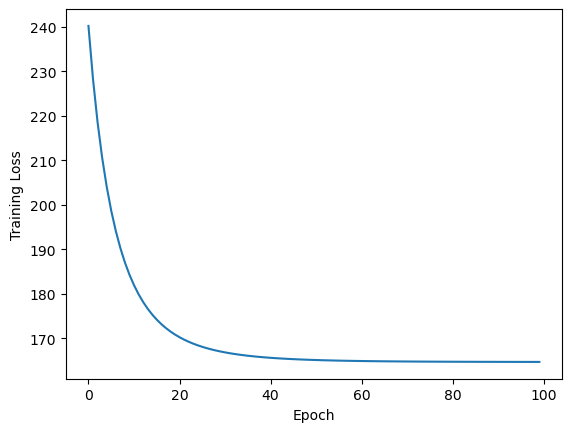

In [33]:
### Code here

# i)
logi = LogisticRegression(alpha=0, t=100, eta=1e-3)
loss = logi.train(X_train, y_train)
loss = [l for i in range(len(loss)) for l in loss[i][0]]
epochs = [i for i in range(1, 101)]
# Plot the training loss over epochs
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [34]:
### Code here 
# ii)
alphas = [np.random.rand() for i in range(20)]
etas = [0.001*np.random.rand() for i in range(20)]
ts = np.random.randint(0, 100, 20)

loss_list = []
models = []
for i in range(20):
    model = LogisticRegression(alphas[i], ts[i], etas[i])
    loss = model.train(X_train, y_train)
    loss = [l for i in range(len(loss)) for l in loss[i][0]]
    min_loss = min(loss)
    loss_list.append(min_loss)
    models.append(model)

min_l = min(loss_list)
idx = loss_list.index(min_l)         
best_model = models[idx]
print("alpha:", best_model.alpha, "t:", best_model.t, "eta:", best_model.eta)

alpha: 0.2783222255138533 t: 83 eta: 0.0009387784941372085


In [37]:
### Code here
# logi vs best_model
pred_logi = logi.predict(X_test)
acc_logi = accuracy_score(y_test, pred_logi)
pred_best = best_model.predict(X_test)
acc_best = accuracy_score(y_test, pred_best)

print("accuracy of 1st scenario:", acc_logi,"\n", "accuracy of 2nd scenario:", acc_best)
print("accuracy between logi and best_model are the same")

accuracy of 1st scenario: 0.8373983739837398 
 accuracy of 2nd scenario: 0.8373983739837398
accuracy between logi and best_model are the same


### Feature Importance

**2.2.8 Interpret your trained model using a bar chart of the model weights. Make sure to label the bars (x-axis) and don't forget the bias term!**

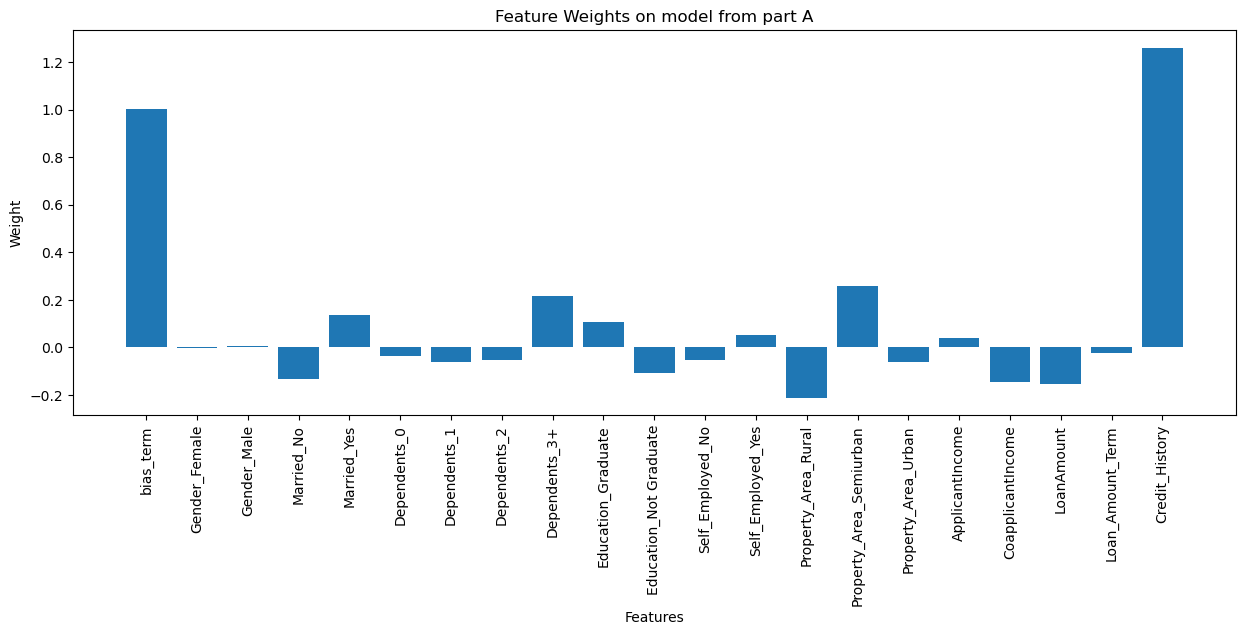

In [38]:
### Code here
w = [w for i in range(len(logi.w)) for w in logi.w[i]]
feature_name = ["bias_term"] + list(loan_X_encoded.columns)
plt.figure(figsize=(15, 5))
plt.bar(feature_name, w)
plt.xlabel('Features')
plt.ylabel('Weight')
plt.title('Feature Weights on model from part A')
plt.xticks(rotation=90)
plt.show()

### Comment here
Both Credit_History is the greatest contributors to the bike count, as both are the two highest height of the bar

### 2.3 Support Vector Machines

In this part, we will be using support vector machines for classification on the loan dataset.

### Train Primal SVM
**2.3.1 Train a primal SVM (with default parameters) on the loan dataset. Make predictions and report the accuracy on the training, validation, and test sets.**

In [39]:
### Code here
primal = LinearSVC()
primal.fit(X_train, y_train)
pred_train_primal = primal.predict(X_train)
pred_val_primal = primal.predict(X_val)
pred_test_primal = primal.predict(X_test)
accuracy_train = accuracy_score(y_train, pred_train_primal)
accuracy_val = accuracy_score(y_val, pred_val_primal)
accuracy_test = accuracy_score(y_test, pred_test_primal)
print("accuracy_train:", accuracy_train, "accuracy_val:", accuracy_val, "accuracy_test:", accuracy_test)

accuracy_train: 0.8179347826086957 accuracy_val: 0.7723577235772358 accuracy_test: 0.8373983739837398


/Users/dawei_banana/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/dawei_banana/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Train Dual SVM
**2.3.2 Train a dual SVM (with default parameters) on the loan dataset. Make predictions and report the accuracy on the training, validation, and test sets.**

In [40]:
### Code here
dual = SVC()
dual.fit(X_train, y_train)
pred_train_dual = dual.predict(X_train)
pred_val_dual = dual.predict(X_val)
pred_test_dual = dual.predict(X_test)
accuracy_train = accuracy_score(y_train, pred_train_dual)
accuracy_val = accuracy_score(y_val, pred_val_dual)
accuracy_test = accuracy_score(y_test, pred_test_dual)
print("accuracy_train:", accuracy_train, "accuracy_val:", accuracy_val, "accuracy_test:", accuracy_test)

accuracy_train: 0.8260869565217391 accuracy_val: 0.7642276422764228 accuracy_test: 0.8292682926829268


/Users/dawei_banana/miniconda3/envs/py38/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
